# N-HiTS 

In [1]:
# !pip install darts

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from darts import TimeSeries

import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tensorflow.keras.layers import MaxPool1D

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (18,12)

In [28]:
df = pd.read_csv('li_price_m1.csv')
df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d')
df.head()

,date_time,traffic_volume
0,2016-01-04,104.0
1,2016-01-05,104.0
2,2016-01-06,104.0
3,2016-01-07,104.0
4,2016-01-08,104.0


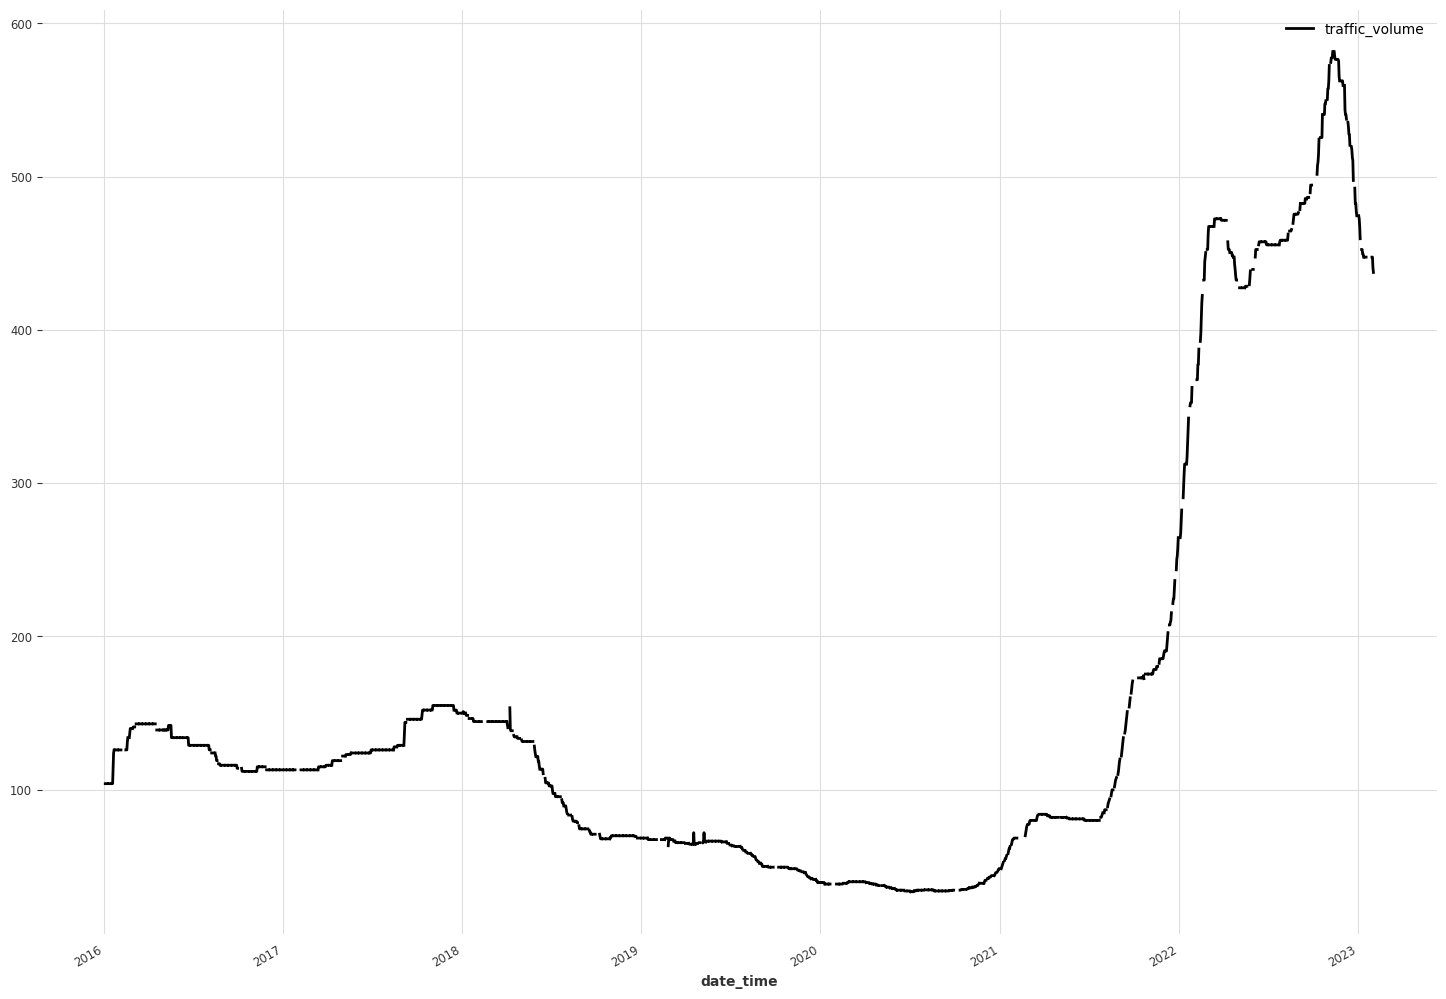

In [29]:
series = TimeSeries.from_dataframe(df, freq='D', fill_missing_dates=True, time_col='date_time')
series.plot()

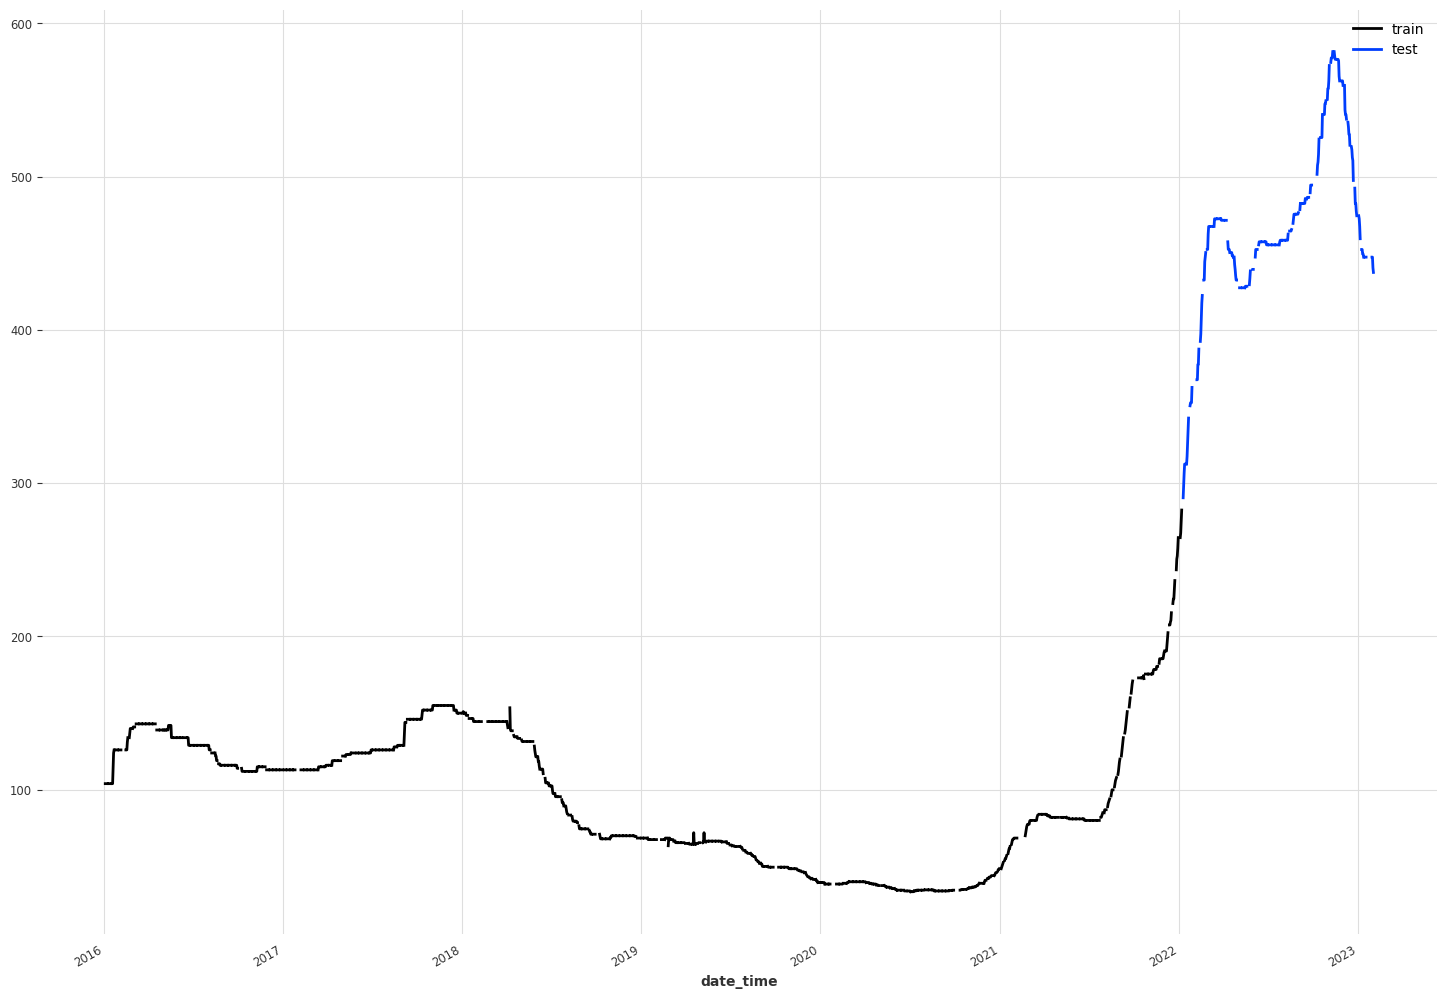

In [31]:
train, test = series[:-390], series[-390:]

train.plot(label='train')
test.plot(label='test')

## Baseline 

In [48]:
from darts.models.forecasting.baselines import NaiveSeasonal

naive_seasonal = NaiveSeasonal(K=390)
naive_seasonal.fit(train)

pred_naive = naive_seasonal.predict(390)

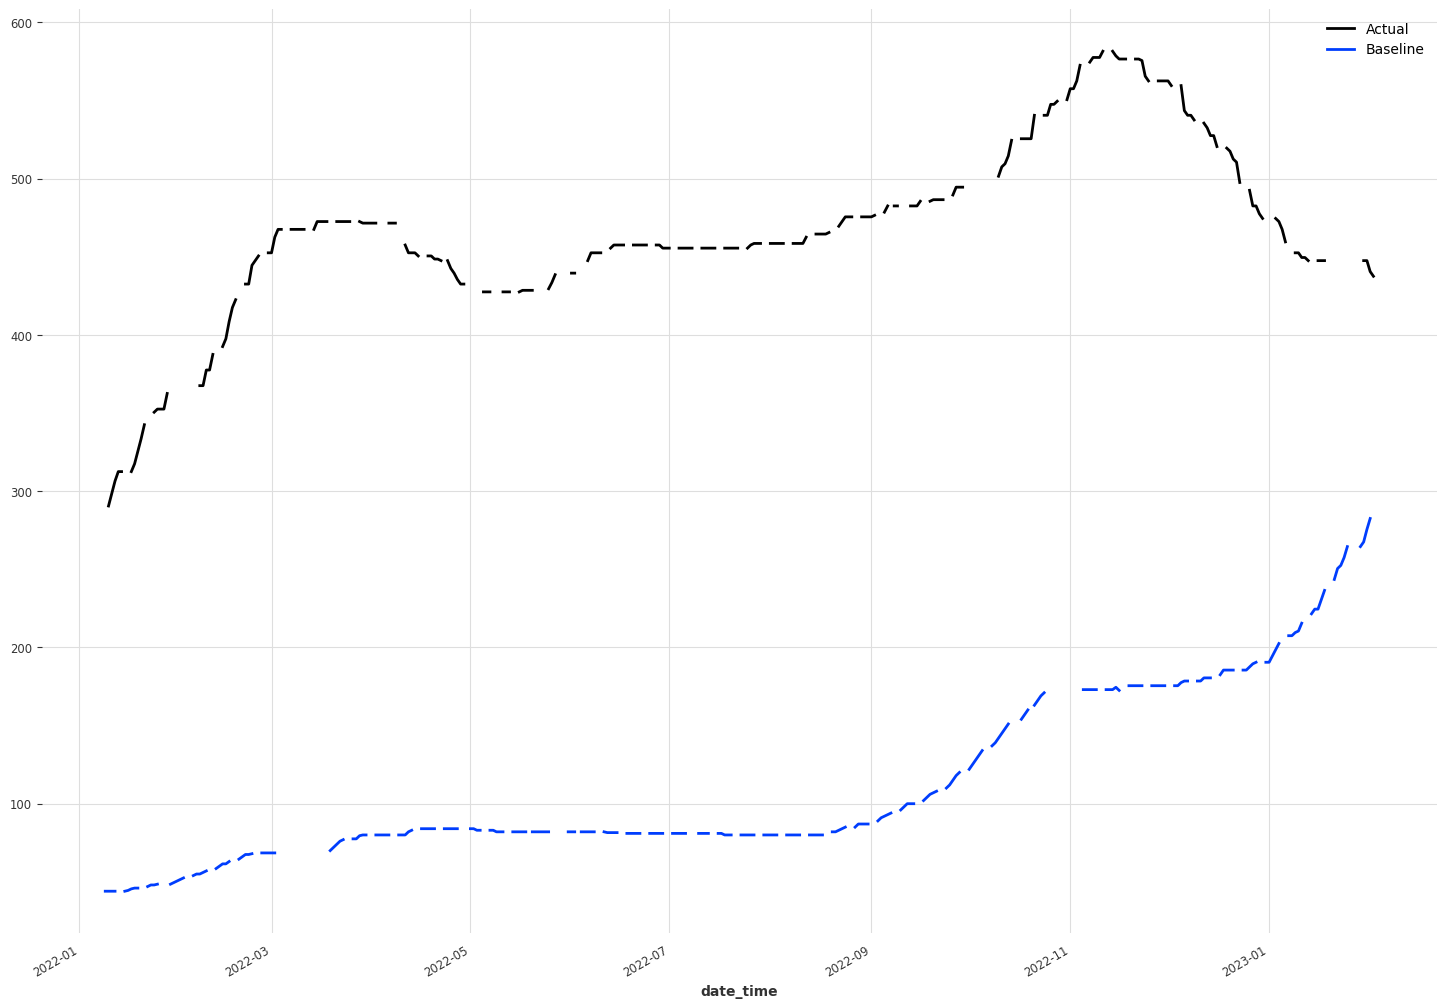

In [49]:
test.plot(label='Actual')
pred_naive.plot(label='Baseline')

In [51]:
from darts.metrics import mae, mape

# naive_mae = mae(test, pred_naive)
naive_mape = mape(test, pred_naive)

# print(naive_mae)
print(naive_mape)

76.36223491513077


### Demonstrate MaxPool

In [52]:
maxpool_l4 = MaxPool1D(pool_size=4, strides=1, padding='same')
maxpool_l12 = MaxPool1D(pool_size=12, strides=1, padding='same')
maxpool_l24 = MaxPool1D(pool_size=24, strides=1, padding='same')

x = df['traffic_volume'].values
x = tf.reshape(x, [1, len(x), 1])

x_maxpooled_l4 = maxpool_l4(x).numpy().flatten()
x_maxpooled_l12 = maxpool_l12(x).numpy().flatten()
x_maxpooled_l24 = maxpool_l24(x).numpy().flatten()


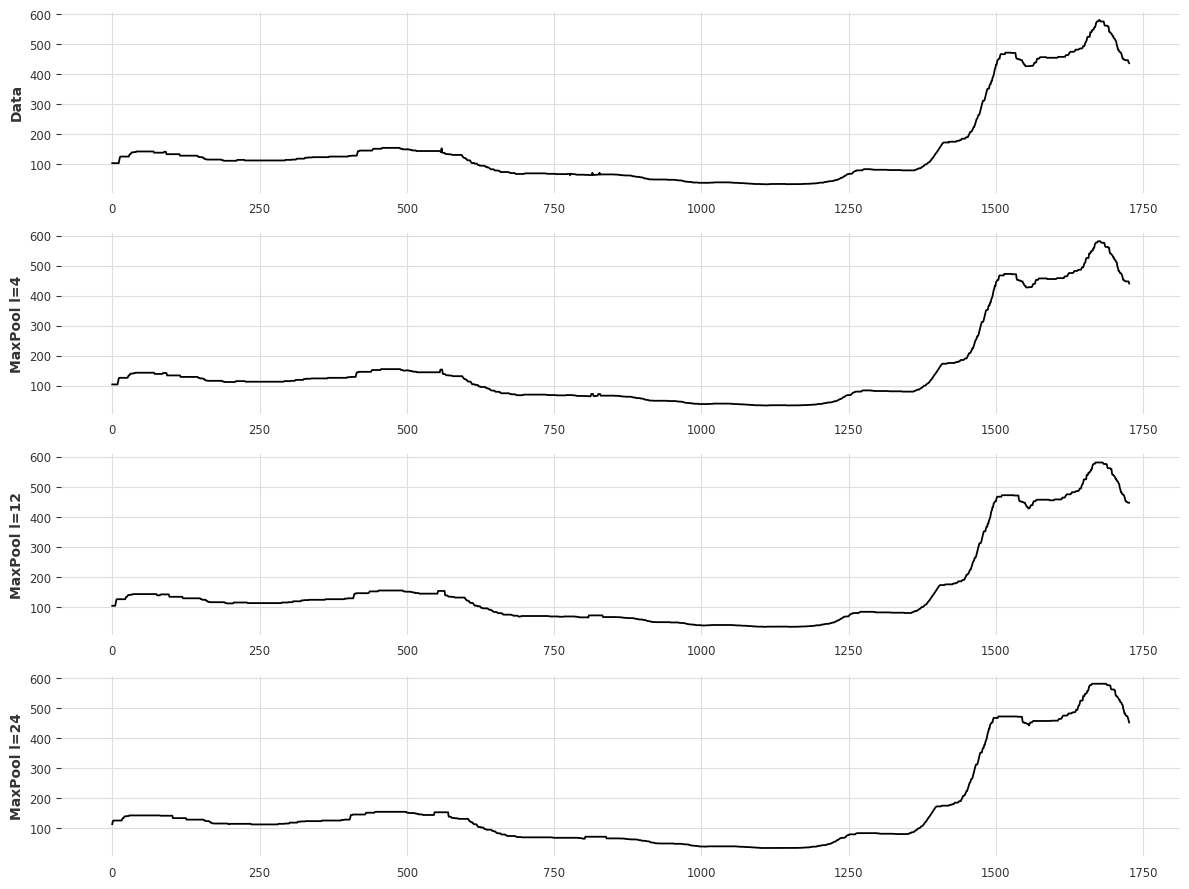

In [53]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(12,9))

ax1.plot(df['traffic_volume'])
ax1.set_ylabel('Data')

ax2.plot(x_maxpooled_l4)
ax2.set_ylabel('MaxPool l=4')

ax3.plot(x_maxpooled_l12)
ax3.set_ylabel('MaxPool l=12')

ax4.plot(x_maxpooled_l24)
ax4.set_ylabel('MaxPool l=24')

plt.tight_layout()

## Apply N-HiTS 

In [71]:
from darts.models import NHiTSModel
from darts.dataprocessing.transformers import Scaler

train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

nhits = NHiTSModel(
    input_chunk_length=120, 
    output_chunk_length=12,
    random_state=42)

nhits.fit(
    scaled_train,
    epochs=50)

scaled_pred_nhits = nhits.predict(n=12)
pred_nhits = train_scaler.inverse_transform(scaled_pred_nhits)

mae_nhits = mae(test, pred_nhits)

print(mae_nhits)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 974 K 
---------------------------------------------------
912 K     Trainable params
61.6 K    Non-trainable params
974 K     Total params
7.792     Total estimated model params size (MB)


Epoch 49: 100%|████████████████████████████████████████████| 65/65 [00:01<00:00, 34.41it/s, loss=nan, train_loss=nan.0]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.93it/s]
nan


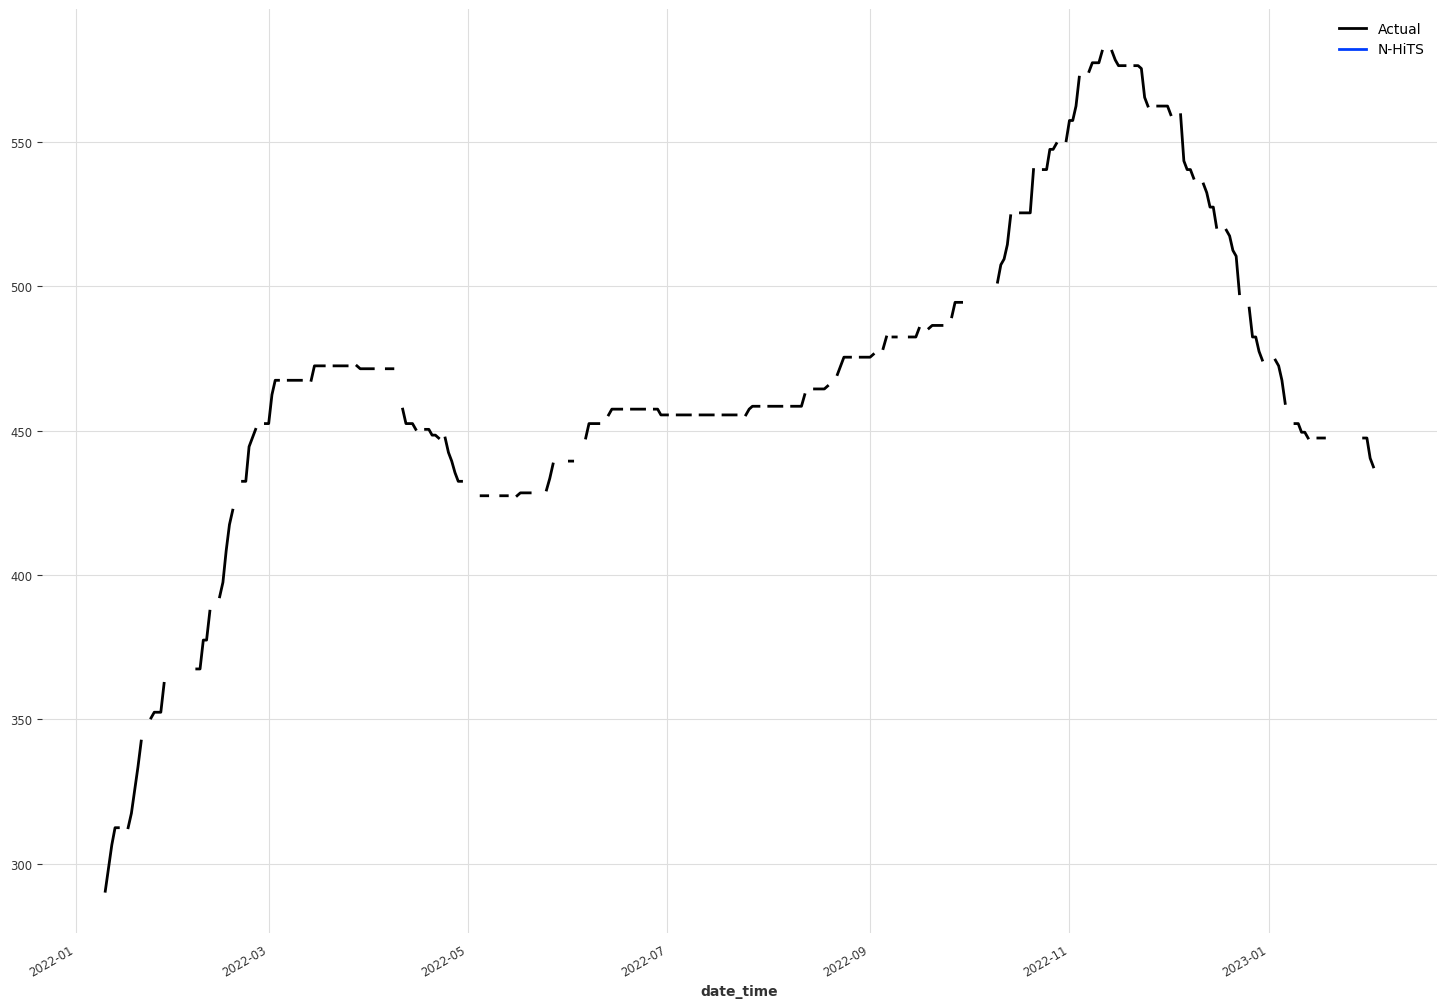

In [72]:
test.plot(label='Actual')
pred_nhits.plot(label='N-HiTS')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


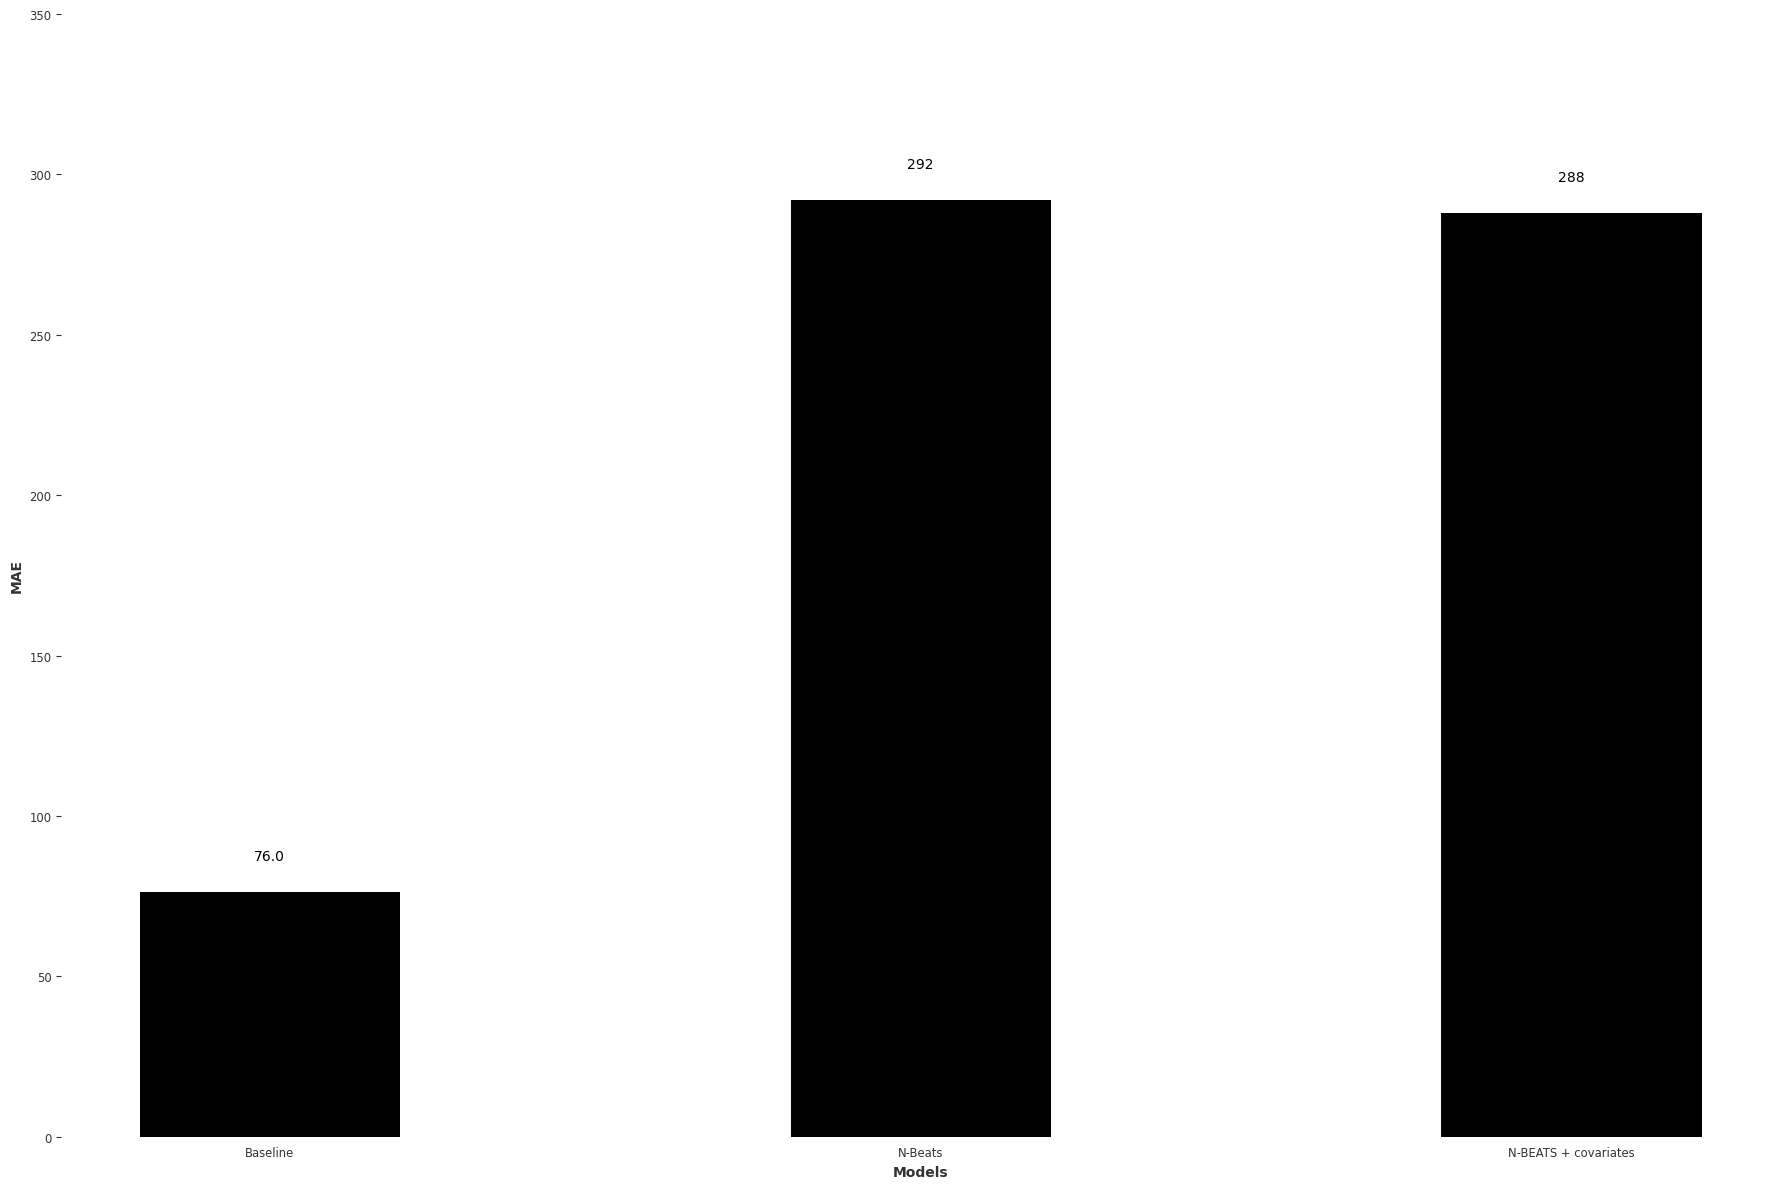

In [68]:
fig, ax = plt.subplots()

x = ['Baseline', 'N-Beats', 'N-BEATS + covariates', 'N-HiTS']
y = [naive_mae, 292, 288, mae_nhits]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.set_ylim(0, 350)
ax.grid(False)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 10, s=str(round(value,0)), ha='center')

plt.tight_layout()